# Datasets

In [47]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt

# Implementation of K-Means Clustering

We implement the class `KMeanClustering`. The implementation of the cluster-kmeans algorithm is in the `fit` method.

In [53]:
class KMeanClustering:
    def __init__(self, K, epsilon=1e-5, max_iter=200):
        if K < 1:
            raise ValueError("K must be greater than 0. Clustering requires at least one Cluster.")
        self.K = K
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.mu = None
        self.P = None
        self.inertia_ = None

    def fit(self, X):
        N, M = X.shape
        mu = np.zeros((self.K, M))

        mu[0] = X[np.random.randint(0, N)]

        for k in range(1, self.K):
            distances = np.zeros(N)

            for i, x in enumerate(X):
                distances[i] = np.sum([np.linalg.norm(x - mu[j]) for j in range(k)])

            i_k = np.argmax(distances)
            mu[k] = X[i_k]

        for epoch in range(self.max_iter):
            mu_old = mu.copy()
            self.P = np.zeros(N, dtype=int)

            for n in range(N):
                distances_to_centroids = [np.linalg.norm(X[n] - mu[k]) for k in range(self.K)]
                self.P[n] = np.argmin(distances_to_centroids)

            for k in range(self.K):
                points_in_cluster = X[self.P == k]
                if len(points_in_cluster) > 0:
                    mu[k] = np.mean(points_in_cluster, axis=0)

            centroid_shift = np.linalg.norm(mu - mu_old, axis=1).mean()
            if centroid_shift < self.epsilon:
                break
        else:
            print('WARNING: Centroid shift convergence not reached.')

        self.mu = mu

        self.inertia_ = sum(np.linalg.norm(X[n] - mu[self.P[n]]) ** 2 for n in range(N))

    def predict(self, X):
        predictions = np.zeros(len(X), dtype=int)
        for n in range(len(X)):
            distances_to_centroids = [np.linalg.norm(X[n] - self.mu[k]) for k in range(self.K)]
            predictions[n] = np.argmin(distances_to_centroids)
        return predictions

According to the sheet, we can decide whether to use $D_1$ or $D_2$, so we decide to use the iris dataset $D_1$.

We use `fetch_iris` from `data_handler` to fetch the dataset and `load_svmlight_file` from `sklearn.datasets` to load the file.

In [54]:
from data_handler import fetch_iris

iris_path = 'data/iris/iris.scale'

fetch_iris(iris_path)

D1_data, D1_labels = load_svmlight_file(iris_path)

D1_data = D1_data.toarray()

File downloaded and saved as data/iris/iris.scale


Capturing the accuracy does not work to measure the model's performance, because of the **unsupervised** algorithm, so the cluster labels generated my K-Means do not necessarily match the original class labels. As [this article](https://opendatascience.com/unsupervised-learning-evaluating-clusters/) from opendatasience.com suggests, we use the **Elbow Method** to choose the optimal value for $K$.

For each $K$, we calculate the Interia (Already implemented in the `KMeanClustering` class)
$$
\text{Inertia} = \sum_{k=1}^K \sum_{x_i \in C_k} \| x_i - \mu_k \|^2
$$
and plot it to find the "elbow".

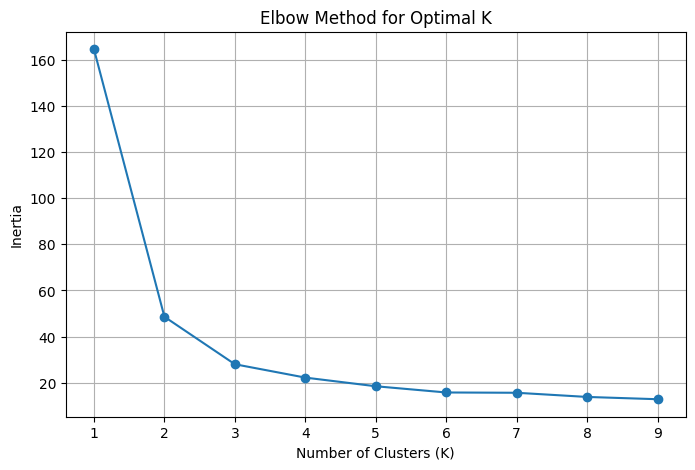

In [57]:
def predict_measure_D1():
    inertias = []
    Ks = range(1, 10)

    for K in Ks:
        model = KMeanClustering(K)
        model.fit(D1_data)

        inertias.append(model.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(Ks, inertias, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.grid()
    plt.show()


predict_measure_D1()

In this figure, we can see a sharp decrease between $K = 1$ and $K = 2$. This indicates a a significant improvement when moving from 1 to 2 clusters. A noticeable "elbow" appears around $K = 3$, where the rate of decrease slows down. Beyond $K = 3$, there are only slight reductions, suggesting the "elbow" point is likely at $K = 3$.

Since we know the actual number of unique labels, we can approve the optimal value for $K$ is indeed $3$.

In general, there is justified criticism of the elbow method because it is considered "both subjective and unreliable" ([Wikipedia](https://en.wikipedia.org/wiki/Elbow_method_(clustering))).